## 文本预处理
在序列处理问题过程中，存在很多种序列学习的形式，例如一篇文章可以简单的看作一串单词序列、甚至是一串字符串序列，这里需要将文本解析转换为不同的token。常见的解析问题的步骤包括：
1. 获取或者制作文本数据集
2. 将文本作为字符串加载到内存中
3. 将字符串转换为token
3. 建议一个dictionary，将token mapping 到 number
5. 将文本转换成为数字索引序列，方面模型操作


In [1]:
import collections
import re

In [2]:
# 预先从Google上搜到timetable.txt prompt:timemachine filetype:txt
# Txt -> python.string
with open('../data/timemachine.txt') as f:
    lines = f.readlines()
    rawDataset = [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]

In [3]:
# python.string -> token

def Corpus(rawDataset,tokenType):
    if tokenType == 'char':
        '''如果是按照char来划分词元'''
        tokenDataset = [list(line) for line in rawDataset]
    elif tokenType == 'word':
        '''如果是按照word来划分词元'''
        tokenDataset = [line.split() for line in lines]
    return  [chars for lines in tokenDataset for chars in lines]
corpus = Corpus(rawDataset,'char')

In [4]:
# Token ->(vocabulary or something)-> Vector

###############################################
# Define:
# Vocabulary:词表，用于将Python.string的Token映射到0开始的数据Vector
# Corpus:语料，将训练集合中所有的文档合并在一起，对唯一词元进行统计,里面全部为token
# TRICK:根据每个词元出现的频率，为其分配数字索引，很少出现的词语通常会被移除，这样来降低复杂性
# TRICK:corpus中不存在或者已经删除都可以映射成为一个特定的token，比如'<unk>'
# TRICK:可以选择增加一个列表，用于保存已经存在的列表，比如'<pad>','<bos>','<eos>'
###############################################

class vocab:
    def __init__(self,tokenDataset,min_freq=0):
        '''
        定义一个词表 vocabulary
        将 python.list(python.string) -> python.list[python.tuple(python.string,python.tuple)]
        '''
        token = []

        # 定义保留的token
        reserved_tokens = []
        counter = collections.Counter(tokenDataset)
        # print(counter)

        # 按照出现频率排序
        self._token_freq = sorted(counter.items(),key=lambda x:x[1],reverse=True)

        # step1:添加未知词元和保留词元
        self.idx_to_token = ['<unk>']+reserved_tokens
        self.token_to_idx = {token:index for index,token in enumerate(self.idx_to_token)}

        # step2:添加根据频率得到的词元，按照频率进行排序
        # 可以看出除了freq排序之外，应该还有其他的方法
        for token,freq in self._token_freq:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk())
        return [self.__getitem__(token) for token in tokens]
    
    def unk(self):
        return 0
    
    def token_freq(self):
        return self._token_freq

# voc = vocab(corpus)
# for i in range(10):
#     print(corpus[i])
#     print(voc[corpus[i]])

## 文本统计
上述文本预处理的过程，成功将 
txt 
-> python.string 
-> corpus(tokenize) 
-> voc(based on freq)
后续我们可以对其进行一定的统计分析，站在Assumption的基础上

Assumption：基本的概率规则
为了训练语言模型，我们需要计算单词的概率，以及给定前面几个单词之后出现某个单词的条件概率，这些概率本质上是语言模型的参数
一种常见的方式是使用频率代替概率，使用出现的次数计算，但是这样的坏处在三元组或者更多的情况下，出现次数较低。一种常见的方式是使用Laplace平滑，也就是增加一个洗哦的常量，但是这样的模型容易变得无效。

IDEA：这种方式是可学习的，说明有可能用其他的方式来得到更好的计算概率的方式

/var/folders/c7/cm14vhdj4pg24ynjxgy8pgd40000gn/T/ipykernel_21752/3711440412.py:6: RuntimeWarning: divide by zero encountered in log10
  x = [np.log10(x) for x in range(len(freq))]


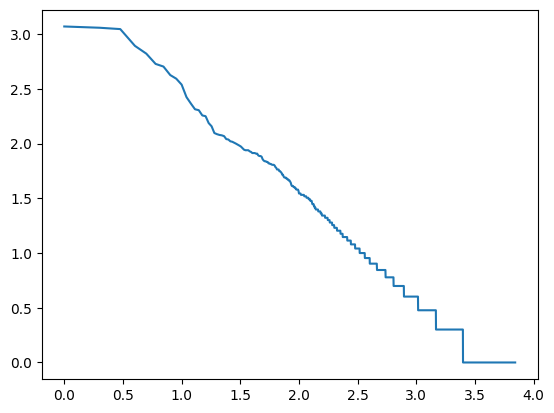

In [5]:
corpus = Corpus(rawDataset,'word')
newVOC = vocab(corpus,min_freq=4)
import numpy as np
freq = [np.log10(t[1]) for t in newVOC.token_freq()]
import matplotlib.pyplot as plt
x = [np.log10(x) for x in range(len(freq))]
plt.plot(x,freq)

/var/folders/c7/cm14vhdj4pg24ynjxgy8pgd40000gn/T/ipykernel_21752/2346354419.py:5: RuntimeWarning: divide by zero encountered in log10
  x = [np.log10(X) for X in range(len(y))]


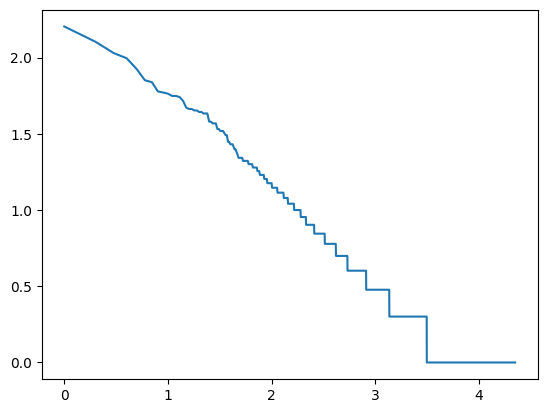

In [6]:
# 之后构建不同元组、1元组、2元组、3元组
binaryGram = [pair for pair in zip(corpus[:-1],corpus[1:])]
binaryVoc = vocab(binaryGram)
y = [np.log10(t[1]) for t in binaryVoc.token_freq()]
x = [np.log10(X) for X in range(len(y))]
plt.plot(x,y)

## 令人惊讶的结论
- 除了一元语法词、单词序列也遵循语言的定律，虽然公式的参数可能不同

- 词表中的n元组并没有那么大，说明语言中存在相当多的结果，这种结构以为着需要更加复杂的模型来学习，单纯的依靠频率是不可行的

- 很多n元组很少出现，这是的拉普拉斯平滑非常不适合语言建模，替代的，需要使用基于深度学习的模型来进行学习。

## 构建数据集
尽管得到了token、corpus和vocab，一次性的将所有的dataset送给神经网络进行学习是一就是困难的，因为我们很难一次性的解决所有的数据集生成，所以这里可以使用常见的两种方式

- (1) 随机采样 random sampling；随机采样中每个样本都是在原始的长序列上任意捕捉子序列，在迭代过程中，来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻。（到目前为止）基于到目前为止看到的tokens来预测下一个token

需要的参数：batchsize、numSteps

- (2) 顺序分区 sequential partitioning

的方式来构建数据集。

总体策略：保证覆盖性和随机性。coverage and randomness

TRICK：为了保证内存小的占有量，在构建dataset的时候，只需要设置好对应的index就行，在之前sin的时间序列预测中，因为本来就是一维的数组


In [7]:
import random
import torch
def randomSampling(corpus,voc,batchsize,num_steps):
    ''' 使用随机抽样生成一个小批量'''
    corpus = corpus[random.randint(0,num_steps-1):]
    num_subseqs = (len(corpus)-1)//num_steps

    # 长度为num_steps的子序列的初始索引,每一个特征的开始
    # 并随机打断
    initial_indices = list(range(0,num_subseqs*num_steps,num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        '''返回从pos位置开始的长度为num_steps的序列'''
        return [voc.__getitem__(token) for token in corpus[pos:pos+num_steps]]
    
    num_batches = num_subseqs // batchsize

    for i in range(0,batchsize*num_batches,batchsize):
        initial_indices_batch = initial_indices[i:i+batchsize]
        X = [data(j) for j in initial_indices_batch]
        Y = [data(j+1) for j in initial_indices_batch]
        # HINT: python.list(torch.tensor)不能之间转换为tensor，需要转换先python.list(python.list)
        # yield torch.tensor([x.tolist() for x in X]),torch.tensor([y.tolist() for y in Y])
        yield torch.tensor(X),torch.tensor(Y)

# testseq = torch.arange(100)
# for x,y in randomSampling(testseq,batchsize=4,num_steps=3):
#     print(x,y)
#     break
    

In [8]:
batchsize = 2
num_steps = 3
data_iter = randomSampling(corpus,newVOC,batchsize,num_steps)

# test for the corpus
# for x,y in data_iter:
#     print(x,y)
#     break

## 模型创建
在上述原始数据获取、数据集制作的过程中，一个重要的特点是我们没有使用torch.utils.data.Dataset和torhc.utils.data.Dataloader，而是用自己的方式写出一个generation，感觉有点奇怪，这里需要看一下是否有更加巧妙的方法。

这里的pipeline总结：
txt文件 --> python.string -->python.list -->tokenize to corpus -->create voc(based on freq)
--> dataloader(based on the randomSampling and sequentitalPartition)

由此我们得到对应的batch size和num steps的train_iter,之后可以构建模型开始训练
注意这里的输入是 batchsize * num_step,输出也是batchsize * num_step; 因为这里的feature size不是1，所以不需要设置，之后的学习过程应该设置 batchsize * num_step * feature dimension

这里依旧采用Recurrent network作为learner，这里需要一点基本的知识，作为模型的神经网络化。同时是用MLP的基础上诞生的
1. 无隐藏状态的单纯的MLP
2. 有隐藏状态的RNN

循环神经网络的好处包括
1. 对隐藏状态使用循环计算的神经网络
2. 循环神经网络的隐状态可以直接捕捉到当前时间序列的历史信息
3. 循环神经网络的参数数量不会随着时间步的增加而增加
4. 可以使用循环神经网络来创建字符的语言模型

In [9]:
# onehot 编码
from torch.nn import functional as F
# for x,y in data_iter:
#     print(F.one_hot(x),len(newVOC))
#     break

In [10]:
class RNNModelScratch:
    '''手撕 RNN '''
    def __init__(self,vocab_size,num_hiddens,device):
        self.vocabsize,self.num_hiddens,self.device = vocab_size,num_hiddens,device
        self.params = self.get_params()
    
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocabsize).type(torch.float)
        return self.rnn(X,state)
    
    def rnn(self,inputs,state):
        ''' 前向传递 '''
        W_xh,W_hh,b_h,W_hq,b_q = self.params
        H, = state
        outputs = []
        # X.shape = [batchsize,dimension]
        for X in inputs:
            
            H = torch.tanh(torch.mm(X,W_xh) + torch.mm(H,W_hh) + b_h)
            Y = torch.mm(H,W_hq) + b_q
            outputs.append(Y)
        
        # Hint:使用torch.cat 也可以解决python.list(torch.tensor)不能合并的问题
        return torch.cat(outputs,dim=0),(H,)

    def get_params(self):
        ''' 初始化参数 '''
        self.input = self.output = self.vocabsize

        def normal(shape):
            return torch.randn(size=shape,device = self.device)*0.01
        
        # hidden layer parameters
        W_xh = normal((self.input,self.num_hiddens))
        W_hh = normal((self.num_hiddens,self.num_hiddens))
        b_h = torch.zeros(self.num_hiddens,device=self.device)

        # output layer parameters
        W_ho = normal((self.num_hiddens,self.output))
        b_o = torch.zeros(self.output,device=self.device)
        return W_xh,W_hh,b_h,W_ho,b_o

    
    def begin_state(self):
        '''初始化状态'''
        return (torch.zeros((batchsize,self.num_hiddens),device=self.device),)

device = torch.device('mps')
net = RNNModelScratch(vocab_size=len(newVOC),num_hiddens=512,device=device)
state = net.begin_state()

# for x,y in data_iter:
#     x,y = x.to(device),y.to(device)
#     Y_hat,new_state = net(x,state)
#     break
# Y_hat.shape

In [11]:
# train with the gradient clip
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.params,lr=0.05)
for X,Y in data_iter:
    x,y = X.to(device),Y.to(device)

    # 这里为什么要reshape
    y = y.T.reshape(-1)
    if state == None:
        state = net.begin_state()
    else:
        for s in state:
            '''question:这里的目的是为什么'''
            s.detach_()
    y_hat,state = net(x,state)
    opt.zero_grad()
    l = loss(y,y_hat)
    l.mean().backward()
    opt.step()
    print(l.mean())


: 

: 